COMIENZA CARGA DE DATOS

Cargo en primer lugar las librerias que usaré, luego cargo el set de datos elegido; este contiene datos de siniestros de tránsito en la Ciudad de Buenos Aires, entre los años 2015 y 2018. 

In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [3]:
siniestros = 'victimas-siniestros.csv'
sin_df = pd.read_csv(siniestros)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\1239150759.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sin_df = pd.read_csv(siniestros)


COMIENZA EL PROCESO DE LIMPIEZA DEL DATASET

In [4]:
sin_df.sample(3)

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,semestre,x,y,geom,cantidad_victimas,comuna,geom_3857,tipo_colision1,participantes_victimas,participantes_acusados
25870,lesiones,conductor,moto,masculino,22.0,3.0,2015,03-09-15,19:30:00,avda juan b alberdi & timoteo gordillo,...,1,-58.508777,-34.656709,0101000020E6100000A8797D9C1F414DC052D247090F54...,1,9.0,0101000020110F000024D63AD283D858C1DD5CBB47A769...,vehiculo - motovehiculo,moto,automovil
32815,lesiones,peaton,peaton,femenino,45.0,3.0,2018,3/25/2018,21:30:00,NaN,...,1,-58.519755,-34.639008,0101000020E61000008BA31B5187424DC0BEE50607CB51...,1,9.0,0101000020110F00005285B951B5D958C196C43CB3F964...,peaton - vehiculo,peaton,taxi/remis
25794,lesiones,pasajero,moto,femenino,25.0,3.0,2015,03-08-15,16:20:00,avda f alcorta y avda sarmiento,...,1,-58.411781,-34.571861,0101000020E6100000BB96F339B5344DC016E09ABF3249...,1,14.0,0101000020110F0000DC9CFB6AF8CD58C1EA8D44F83C53...,multiple,moto,"automovil,moto"


In [5]:
sin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33234 entries, 0 to 33233
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   causa                         33234 non-null  object 
 1   rol                           32899 non-null  object 
 2   tipo                          32134 non-null  object 
 3   sexo                          33037 non-null  object 
 4   edad                          32675 non-null  float64
 5   mes                           33197 non-null  float64
 6   periodo                       33234 non-null  int64  
 7   fecha                         33173 non-null  object 
 8   hora                          33217 non-null  object 
 9   lugar_hecho                   29518 non-null  object 
 10  direccion_normalizada         32469 non-null  object 
 11  tipo_calle                    33234 non-null  object 
 12  direccion_normalizada_arcgis  32462 non-null  object 
 13  c

EN PRIMERA INSTANCIA DE LA EXPLORACION, VOY A ESTABLECER UN OBJETIVO GENERAL:

- QUIERO MINIMIZAR LA CANTIDAD DE ACCIDENTES DE AUTOS, MOTOS Y BICICLETAS (en este ejemplo me contrataría gobierno de la Ciudad de Buenos Aires). PARA ESTO HABRIA QUE TOMAR MEDIDAS DE TODO TIPO, COMO CONTROLES POLICIALES, CARTELES PREVENTIVOS, ARREGLOS DE CALLE, CAMARAS-MULTA, ETC.

-------------------------------------------------------------------------------------------------------------------------------

CON ESTE OBJETIVO EN MENTE, VOY A ELEGIR QUE COLUMNAS SON LAS QUE MAS INFORMACION PUEDEN APORTAR Y CUALES SON LAS QUE TIENEN INFORMACION REDUNDANTE.

EN UNA PRIMERA IMPRESION, ASUMO QUE LAS COLUMNAS MAS IMPORTANTES SON:

- causa
- rol
- tipo
- sexo
- edad
- fecha
- hora
- tipo_calle
- calle1
- calle2
- x
- y
- cantidad_victimas
- comuna
- participantes_victimas
- participantes_acusados

EL RESTO DE COLUMAS CONTIENEN INFORMACION QUE APARECE EN ESTAS COLUMNAS SELECCIONADAS, PERO EN OTRO FORMATO.

PROCEDO A QUEDARME SOLO CON LAS COLUMNAS ELEGIDAS Y REVISO LOS DATOS NULOS

In [6]:
sin_df = sin_df[['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']]
sin_df.isnull().sum()

causa                        0
rol                        335
tipo                      1100
sexo                       197
edad                       559
fecha                       61
hora                        17
tipo_calle                   0
calle1                     765
calle2                    8247
x                         1095
y                         1095
cantidad_victimas            0
comuna                    1098
tipo_colision1            1343
participantes_acusados     677
participantes_victimas    1131
dtype: int64

In [7]:
sin_df.loc[sin_df.comuna.isnull()][['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']].isnull().sum()

causa                        0
rol                          6
tipo                        41
sexo                         6
edad                        29
fecha                        6
hora                         6
tipo_calle                   0
calle1                     739
calle2                    1097
x                         1095
y                         1095
cantidad_victimas            0
comuna                    1098
tipo_colision1              43
participantes_acusados      17
participantes_victimas      38
dtype: int64

BORRO LAS FILAS QUE TIENEN EL CAMPO FECHA Y HORA VACIOS, PORQUE SON MUY POCOS DATOS QUE PIERDO.

In [8]:
sin_df.dropna(subset=['fecha','hora'],inplace=True)
sin_df[['fecha','hora']].isnull().sum()

fecha    0
hora     0
dtype: int64

AHORA VOY A SIMPLIFICAR LAS COLUMNAS 'tipo' Y 'tipo_colision1' PARA QUE SEAN UTILIZABLES.

In [9]:
sin_df['tipo_colision1'].fillna('sin_data',inplace=True)
sin_df['tipo'].fillna('sin_data',inplace=True)

def simplificar_tipocol(tipo):

    if '-' in tipo:
        ac, vi = tipo.split('-')
    else:
        return tipo
    
    if tipo == 'vehiculo - motovehiculo' or tipo == 'motovehiculo - vehiculo':
        return 'motovehiculo - vehiculo'
    elif tipo == 'vehiculo - peaton' or tipo == 'peaton - vehiculo':
        return 'peaton - vehiculo'
    elif tipo == 'vehiculo - bicicleta' or tipo == 'bicicleta - vehiculo':
        return 'bicicleta - vehiculo'
    elif tipo == 'traccion a sangre - vehiculo' or tipo == 'motovehiculo - traccion a sangre' or tipo == 'motovehiculo - tren' or tipo == 'subte - vehiculo':
        return 'sin_data'
    elif 'bicicleta' in tipo:
        return 'bicicleta'
    elif 'peaton' in tipo:
        return 'peaton'
    else:
        return tipo

def simplificar_tipo(tipo):
    
    if tipo == 'auto pfa / movil / gendarmeria / metropolitana / moto movil' or tipo == 'vehiculo oficial':
        st = 'fuerza seguridad'
    elif tipo == 'transporte de cargas / grua' or tipo == 'utilitario':
        st = 'camion'
    elif tipo == 'transporte escolar' or tipo == 'omnibus / minibus':
        st = 'transporte publico'
    elif tipo == 'ambulancia':
        st = 'camioneta'
    elif tipo == 'traccion a sangre' or tipo == 'autobomba' or tipo == 'patineta' or tipo == 'cuatriciclo' or tipo == 'tren / subte' or tipo == 'tren / subte / tranvia' or tipo == 'vehiculo rural' or tipo == 'otros':
        st = 'sin_data'
    else:
        return tipo
    return st

In [10]:
sin_df['tipo'] = sin_df['tipo'].apply(simplificar_tipo)#.astype('|S80')

sin_df['tipo_colision1'] = sin_df['tipo_colision1'].apply(simplificar_tipocol)#.astype('|S80')

sin_df[['tipo','tipo_colision1']].describe()

,tipo,tipo_colision1
count,33162,33162
unique,10,9
top,moto,motovehiculo - vehiculo
freq,12989,11378


DEBERIA RELLENAR LOS NULOS DE 'tipo' CON INFORMACION DE OTRAS COLUMNAS PARA MEJORAR LA CALIDAD DE LA INFORMACION

AHORA VOY A RELLENAR LOS CAMPOS CON VALOR NULO

In [11]:
#sin_df['comuna'].fillna(0,inplace=True)
sin_df = sin_df.dropna(subset='comuna')
sin_df['comuna'] = sin_df['comuna'].astype(int)

In [12]:
sin_df['rol'].fillna('sin_data',inplace=True)
sin_df['sexo'].fillna('sin_data',inplace=True)
sin_df['calle1'].fillna('sin_data',inplace=True)
sin_df['calle2'].fillna('sin_data',inplace=True)
sin_df['participantes_acusados'].fillna('sin_data',inplace=True)
sin_df['participantes_victimas'].fillna('sin_data',inplace=True)
sin_df['x'].fillna(-1,inplace=True)
sin_df['y'].fillna(-1,inplace=True)
sin_df['edad'].fillna(sin_df.edad.mean(),inplace=True)

EN LOS SIGUIENTES CASILLEROS VOY A LIMPIAR Y NORMALIZAR COLUMNAS

In [13]:
def normalizar_causa(causa):
    if causa == 'lesiones':
        return 0
    elif causa == 'homicidio':
        return 1
    else:
        return -1


def normalizar_sexo(sexo):
    if sexo == 'masculino':
        return 1
    elif sexo == 'femenino':
        return 2
    else:
        return 0
    
def normalizar_tipo_calle(calle):
    if calle == 'autopista':
        return 1
    elif calle == 'avenida':
        return 2
    elif calle == 'calle':
        return 3
    else:
        return 0
    
sin_df['sexo'] = sin_df['sexo'].apply(normalizar_sexo)
sin_df['causa'] = sin_df['causa'].apply(normalizar_causa)
sin_df['tipo_calle'] = sin_df['tipo_calle'].apply(normalizar_tipo_calle)
sin_df.value_counts('tipo_calle')

# masculino -> 1
# femenino -> 2
# sin data -> 0

# lesiones -> 1
# muerte -> 2

tipo_calle
2    21127
3    10838
1      106
dtype: int64

In [14]:
def edades(edad):
    rango = 0
    
    if (edad<20):
        rango=1
    elif (edad<40):
        rango=2
    elif (edad<60):
        rango=3
    else:
        rango=4
    return rango

sin_df['rango_edad'] = sin_df['edad'].apply(edades)
sin_df.value_counts('rango_edad')

rango_edad
2    18569
3     7176
4     3518
1     2808
dtype: int64

LE DOY UN FORMATO DESEADO A LA HORA Y FECHA

In [15]:
def extraer_hora(hora):
    return hora.hour

sin_df['hora'] = pd.to_datetime(sin_df['hora']).apply(extraer_hora)
sin_df['hora'] = sin_df['hora'].astype(int)
sin_df.value_counts('hora').head()

hora
18    2141
13    2129
14    2050
17    2022
12    1967
dtype: int64

In [16]:
def crear_fecha(fecha):

    if "/" in fecha:
        fecha = fecha.split("/")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        aux = fecha[1]
        fecha[1] = fecha[0]
        fecha[0] = aux
        return fecha
    
    elif "-" in fecha:
        fecha = fecha.split("-")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        fecha[2] = 2000 + fecha[2]
        return fecha


def dia(d):
    return d[0]

def mes(d):
    return d[1]

def anio(d):
    return d[2]

In [17]:
sin_df['rango_horario'] = sin_df.hora.apply(lambda x: 
                                            0 if (x < 5)
                                            else 1 if (x < 14)
                                            else 2 if (x < 21)
                                            else 0)

sin_df.rango_horario.value_counts()

# 0 -> Noche y Madrugada
# 1 -> Mañana
# 2 -> Tarde

2    13504
1    12988
0     5579
Name: rango_horario, dtype: int64

In [18]:
#sin_df = sin_df.dropna(subset='fecha')
sin_df['fecha_norm'] = sin_df['fecha'].apply(crear_fecha)

sin_df['d'] = sin_df['fecha_norm'].apply(dia)
sin_df['m'] = sin_df['fecha_norm'].apply(mes)
sin_df['a'] = sin_df['fecha_norm'].apply(anio)

sin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32071 entries, 0 to 33232
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   causa                   32071 non-null  int64  
 1   rol                     32071 non-null  object 
 2   tipo                    32071 non-null  object 
 3   sexo                    32071 non-null  int64  
 4   edad                    32071 non-null  float64
 5   fecha                   32071 non-null  object 
 6   hora                    32071 non-null  int32  
 7   tipo_calle              32071 non-null  int64  
 8   calle1                  32071 non-null  object 
 9   calle2                  32071 non-null  object 
 10  x                       32071 non-null  float64
 11  y                       32071 non-null  float64
 12  cantidad_victimas       32071 non-null  int64  
 13  comuna                  32071 non-null  int32  
 14  tipo_colision1          32071 non-null

In [19]:
#sin_df[['tipo_colision1','tipo','participantes_acusados','participantes_victimas']].sample(10)
sin_df.participantes_acusados.value_counts()

automovil                                    16212
"transporte publico"                          3660
moto                                          2543
taxi/remis                                    2080
camioneta                                     1400
                                             ...  
taxi/remis,camioneta                             1
moto,automovil,automovil,automovil               1
automovil,ambulancia                             1
"transporte de cargas / grua / volquetes"        1
automovil,cuatriciclo                            1
Name: participantes_acusados, Length: 178, dtype: int64

veo que 'participantes_victimas' contiene en casi todos los casos el mismo valor que la columna 'tipo', por lo cual no la voy a utilizar.
en el caso de la columna 'participantes_acusados' tiene informacion diferente y tendre que limpiar la columna para poder utilizarla.

In [20]:
def simplificar_acusado(ac):    
    if ('moto' in ac):
        return 'motovehiculo'
    elif ('auto' in ac):
        return 'automovil'
    elif (('rural' in ac) | ('camion' in ac) | ('utilitario' in ac)):
        return 'camion'
    elif ('peaton' in ac) | ('patineta' in ac):
        return 'otro'
    elif ('bici' in ac):
        return 'otro'
    elif (('taxi' in ac) | ('remis' in ac) | ('bus' in ac) | ('publico' in ac)):
        return 'transporte_publico'
    elif (('transporte' in ac) | ('ambulancia' in ac) | ('fuerza' in ac) | ('tren' in ac) | ('tranvia' in ac) | ('oficial' in ac)):
        return 'transporte_publico'
    else:
        return 'otro'

sin_df.participantes_acusados = sin_df.participantes_acusados.apply(simplificar_acusado)
sin_df.participantes_acusados.value_counts()

automovil             18478
transporte_publico     6200
motovehiculo           3598
camion                 2788
otro                   1007
Name: participantes_acusados, dtype: int64

FINALIZA EL PROCESO DE LIMPIEZA

AGREGO DATOS DEL CLIMA DE CABA PARA SINIESTRO (utilizando como clave la fecha y hora del mismo)



In [21]:
clima = 'clima_caba.csv'
clima_df = pd.read_csv(clima)
clima_df.rename(columns={'viento;;;;;;':'viento'}, inplace=True)

#NO SE PORQUE AGREGA LA COLUMNA VIENTO CON ESE NOMBRE, PARA NO PERDER TIEMPO LA CORRIJO MANUALMENTE

In [22]:
sin_df = sin_df.merge(clima_df,how='left',left_on=['d','m','a','hora'],right_on=['d','m','a','h'])
sin_df.sample(3)

,causa,rol,tipo,sexo,edad,fecha,hora,tipo_calle,calle1,calle2,...,rango_horario,fecha_norm,d,m,a,h,temp,hum,precip,viento
8270,0,peaton,peaton,1,20.0,02-03-15,13,3,salom,sin_data,...,1,"[2, 3, 2015]",2,3,2015,13,27.43,60.69,0.0,3.44
6589,0,conductor,moto,1,38.0,11/16/2017,12,3,esmeralda,paraguay,...,1,"[16, 11, 2017]",16,11,2017,12,19.91,53.56,0.0,4.21
3877,0,conductor,moto,1,23.0,08-03-16,19,2,cordoba av.,sanchez de bustamante,...,2,"[8, 3, 2016]",8,3,2016,19,24.03,54.69,0.0,2.60


<AxesSubplot:>

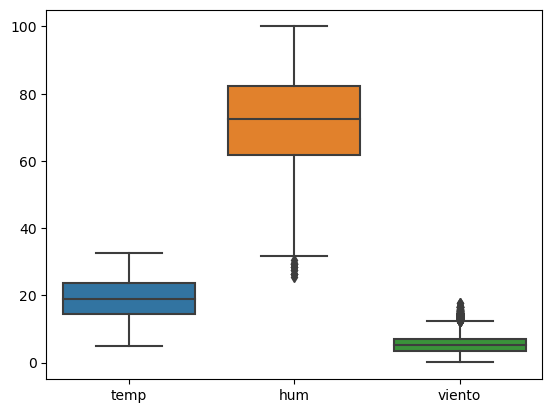

In [23]:
sns.boxplot(sin_df[['temp','hum','viento']])

Veo que en este caso los outliers no cambiaran en gran medida la normalización.

Voy a categorizar las columnas viento y precip para que sean utilizables por los diferentes clasificadores

<AxesSubplot:ylabel='Frequency'>

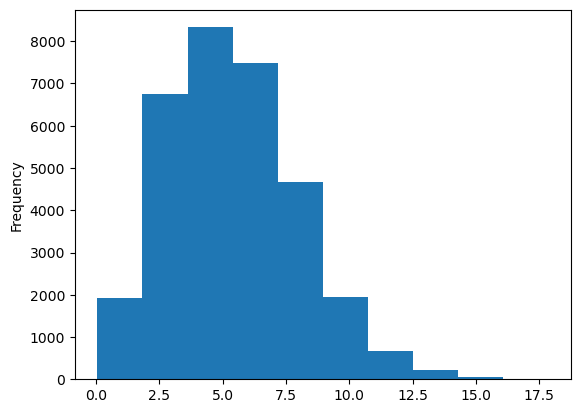

In [24]:
sin_df.viento.plot(kind='hist')

In [25]:
vmod_mask = (sin_df.loc[(sin_df.viento >= 2.5) & (sin_df.viento <= 6)]).index
vmin_mask = (sin_df.loc[(sin_df.viento < 2.5)]).index
vmax_mask = (sin_df.loc[(sin_df.viento > 6)]).index


sin_df.loc[vmin_mask, 'viento'] = 0
sin_df.loc[vmod_mask, 'viento'] = 1
sin_df.loc[vmax_mask, 'viento'] = 2

sin_df.viento = sin_df.viento.astype(int)

sin_df.viento.value_counts()

1    14827
0     9046
2     8198
Name: viento, dtype: int64

In [26]:
p_mask = (sin_df.loc[(sin_df.precip >= 0.1)]).index
no_p_mask = (sin_df.loc[(sin_df.precip < 0.1)]).index

sin_df.loc[p_mask, 'precip'] = 0
sin_df.loc[no_p_mask, 'precip'] = 1

sin_df.precip = sin_df.precip.astype(int)

sin_df.precip.value_counts()

1    28800
0     3271
Name: precip, dtype: int64

In [1]:
#sin_df['clim'] = sin_df.viento + (2*sin_df.precip)

In [27]:
# SE QUE TENGO OUTLIERS EN ESTE FEATURE, HAGO UNA ELIMINACION MANUAL DE ESTOS

#sin_df.precip.sort_values(ascending=False).head(30)

In [28]:
#ELIMINO OUTLIERS DE PRECIPITACION PARA QUE NO INTERFIERA EN LA NORMALIZACION DEL FEATURE, CONSIDERO OUTLIERS A LOS VALORES MAYORES A 12
#sin_df = sin_df.loc[sin_df.precip < 12]


In [29]:
#ESCALO TODOS LOS VALORES DE CLIMA OBTENIDOS ENTRE 0 y 1
#scaler = MinMaxScaler()
#scaled_df = scaler.fit_transform(sin_df[['temp','hum','viento','precip']])
#sin_df[['temp','hum','viento','precip']] = scaled_df

# PUEDO ESCALAR LOS VALORES O PUEDO CATEGORIZARLOS 

EN OTRAS ENTREGAS PUDE EXTRAER INFORMACIÓN DEL SET DE DATOS QUE APUNTABA A ENCONTRAR LOS PUNTOS CLAVE EN LOS QUE SE DABA LA MAYOR CANTIDAD DE SINIESTROS DE CADA TIPO (las calles, comunas y coordenadas mas peligrosas para cada tipo de vehiculo), ESTOS DESCUBRIMIENTOS SON LOS INSIGHTS QUE ME PARECIERON IMPORTANTES EN VISTA A PROPONER MEDIDAS QUE AYUDEN A BAJAR LA CANTIDAD DE ACCIDENTES. 

EN ESTA ENTREGA ME CENTRARÉ EN LA PREDICCIÓN; PARA ESTO VOY A ENTRENAR UN MODELO DE MACHINE LEARNING, HABIENDO HECHO LA SELECCIÓN DE FEATURES QUE CREA NECESARIO PARA EL CASO.

Primero voy a predecir una variable importante desde mi punto de vista, el tipo de calle en el que se produce un siniestro, dadas las columnas elegidas como variable independiente, para el caso: 

'causa','tipo','rol','sexo','rango_horario','comuna','tipo_colision1','d','m','a','participantes_acusados','precip','viento','rango_edad'

In [30]:
X = sin_df[['causa','tipo','rol','sexo','rango_horario','comuna','tipo_colision1','d','m','a','participantes_acusados','precip','viento','rango_edad']]
y = sin_df['tipo_calle']

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32071 entries, 0 to 32070
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   causa                   32071 non-null  int64 
 1   tipo                    32071 non-null  object
 2   rol                     32071 non-null  object
 3   sexo                    32071 non-null  int64 
 4   rango_horario           32071 non-null  int64 
 5   comuna                  32071 non-null  int32 
 6   tipo_colision1          32071 non-null  object
 7   d                       32071 non-null  int64 
 8   m                       32071 non-null  int64 
 9   a                       32071 non-null  int64 
 10  participantes_acusados  32071 non-null  object
 11  precip                  32071 non-null  int32 
 12  viento                  32071 non-null  int32 
 13  rango_edad              32071 non-null  int64 
dtypes: int32(3), int64(7), object(4)
memory usage: 4.3+ MB

In [31]:
#X = pd.get_dummies(X)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X.rol)
X.rol = le.transform(X.rol)

le.fit(X.tipo_colision1)
X.tipo_colision1 = le.transform(X.tipo_colision1)

le.fit(X.participantes_acusados)
X.participantes_acusados = le.transform(X.participantes_acusados)

le.fit(X.tipo)
X.tipo = le.transform(X.tipo)


C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\3019221700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rol = le.transform(X.rol)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\3019221700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.tipo_colision1 = le.transform(X.tipo_colision1)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\3019221700.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [33]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
modelo_rf.fit(X_train, y_train)

y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\1080219172.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


% de aciertos sobre el set de entrenamiento: 69.47748229319791
% de aciertos sobre el set de evaluación: 66.0361671170235


Es un buen resultado, voy a compararlo con otro algoritmo, utilizando las mismas variables X e y 

In [34]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

modelo_xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
modelo_xgb.fit(X_train, y_train)

y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


% de aciertos sobre el set de entrenamiento: 69.41511871352844
% de aciertos sobre el set de evaluación: 65.93223861982955


El resultado de la predicción es muy similar utilizando ambos algoritmos, voy a utilizar los consejos recibidos en la 2da preentrega del proyecto final para intentar mejorar estos numeros

EN LA CORRECCIÓN DE LA ENTREGA ANTERIOR, RECIBÍ MUY BUENOS CONSEJOS SOBRE ELEGIR MEJOR MIS FEATURES Y AJUSTAR BIEN LOS HIPERPARAMETROS, EN ESTE CASO VOY A APLICAR EL PRIMERO DE LOS CONSEJOS YA QUE EN LA SUBSIGUIENTE ENTREGA HARE EL AJUSTE DE HIPERPARAMETROS USANDO CROSSVALIDATION, EN ESTE CASO SOLO INTENTARE MEJORARLOS MANUALMENTE.

Como pide la entrega N° 14, COMENZARÉ CON EL FILTRADO DE FEATURES.

In [35]:
importancia = pd.DataFrame()
importancia['feature'] = pd.Series(X.columns)
importancia['imp'] = modelo_rf.feature_importances_
importancia.sort_values(by='imp', ascending=False)

,feature,imp
5,comuna,0.145883
7,d,0.142421
8,m,0.109399
6,tipo_colision1,0.096753
1,tipo,0.082856
10,participantes_acusados,0.071790
13,rango_edad,0.066109
2,rol,0.064650
9,a,0.057841
4,rango_horario,0.050375


Esta es la importancia de los features para el modelo de random forest en la predicción del TIPO DE CALLE. Voy a utilizarla como una guia para mi filtrado de features.

UTILIZANDO COMO AYUDA EL FEATURE IMPORTANCE, PRIMERO FILTRARE LOS FEATURES QUE MENOS DATOS APORTEN.

Agregaré una columna que indique si el accidente se produjo en un fin de semana.

In [36]:
from datetime import datetime

sin_df['fecha_norm'] = sin_df['d'].astype(str) + '-' + sin_df['m'].astype(str) + '-' + sin_df['a'].astype(str)
sin_df['fecha'] = pd.to_datetime(sin_df['fecha_norm'],format='%d-%m-%Y', errors='coerce')

sin_df['nom_dia'] = sin_df['fecha'].dt.strftime('%A')

sin_df[['a','m','d','fecha','nom_dia']].sample(3)

,a,m,d,fecha,nom_dia
3134,2016,4,18,2016-04-18,Monday
25376,2015,7,14,2015-07-14,Tuesday
26269,2015,11,25,2015-11-25,Wednesday


In [37]:
sin_df.nom_dia.isnull().sum()

0

Con este sample corroboré que los días esten bien agregados.

In [38]:
mask = (sin_df.loc[(sin_df.nom_dia == 'Sunday') | (sin_df.nom_dia == 'Saturday')]).index

In [39]:
sin_df.loc[mask, 'finde'] = 1
sin_df.loc[sin_df.finde!=1, 'finde'] = 0
sin_df.finde = sin_df.finde.astype(int)
sin_df[['fecha','nom_dia','finde']].sample(10)

,fecha,nom_dia,finde
18167,2015-07-24,Friday,0
13621,2017-05-19,Friday,0
13593,2017-05-15,Monday,0
4811,2016-12-28,Wednesday,0
16340,2015-02-03,Tuesday,0
13702,2017-01-06,Friday,0
21084,2017-01-19,Thursday,0
29952,2017-06-23,Friday,0
11070,2016-04-14,Thursday,0
17722,2015-11-18,Wednesday,0


In [40]:
#sin_df = sin_df.drop(columns={'nom_dia','fecha','fecha_norm','a'})

In [41]:
sin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32071 entries, 0 to 32070
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   causa                   32071 non-null  int64         
 1   rol                     32071 non-null  object        
 2   tipo                    32071 non-null  object        
 3   sexo                    32071 non-null  int64         
 4   edad                    32071 non-null  float64       
 5   fecha                   32071 non-null  datetime64[ns]
 6   hora                    32071 non-null  int32         
 7   tipo_calle              32071 non-null  int64         
 8   calle1                  32071 non-null  object        
 9   calle2                  32071 non-null  object        
 10  x                       32071 non-null  float64       
 11  y                       32071 non-null  float64       
 12  cantidad_victimas       32071 non-null  int64 

Casteo mis columnas

In [42]:
sin_df.d = sin_df.d.astype(int)
sin_df.m = sin_df.m.astype(int)
sin_df.rango_edad = sin_df.rango_edad.astype(int)
sin_df.rango_horario = sin_df.rango_horario.astype(int)

In [43]:
X = sin_df[['viento','precip','comuna','d','m','tipo_colision1','rango_edad','participantes_acusados','rango_horario','finde']]
y = sin_df['tipo_calle']

In [44]:
le.fit(X.tipo_colision1)
X.tipo_colision1 = le.transform(X.tipo_colision1)

le.fit(X.participantes_acusados)
X.participantes_acusados = le.transform(X.participantes_acusados)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32071 entries, 0 to 32070
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   viento                  32071 non-null  int32
 1   precip                  32071 non-null  int32
 2   comuna                  32071 non-null  int32
 3   d                       32071 non-null  int32
 4   m                       32071 non-null  int32
 5   tipo_colision1          32071 non-null  int32
 6   rango_edad              32071 non-null  int32
 7   participantes_acusados  32071 non-null  int32
 8   rango_horario           32071 non-null  int32
 9   finde                   32071 non-null  int32
dtypes: int32(10)
memory usage: 2.5 MB


C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\1637256539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.tipo_colision1 = le.transform(X.tipo_colision1)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\1637256539.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.participantes_acusados = le.transform(X.participantes_acusados)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

Para realizar la comparación con el modelo anterior, utilizo los mismos hiperparametros

In [46]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
modelo_rf.fit(X_train, y_train)

y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\1080219172.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


% de aciertos sobre el set de entrenamiento: 69.74030023609069
% de aciertos sobre el set de evaluación: 66.09852421533985


In [47]:
import xgboost as xgb

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

modelo_xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
modelo_xgb.fit(X_train, y_train)

y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


% de aciertos sobre el set de entrenamiento: 69.01420998708183
% de aciertos sobre el set de evaluación: 65.66202452712534


EN PRINCIPIO LOS RESULTADOS NO MEJORAN SIGNIFICATIVAMENTE AGREGANDO LA COLUMNA "finde"

In [48]:
from sklearn.metrics import precision_score, accuracy_score, f1_score

precision = precision_score(y_test, y_test_pred, average='macro')

accuracy = accuracy_score(y_test, y_test_pred)

f1 = f1_score(y_test, y_test_pred, average='macro')

print("Precisión:", precision)
print("Exactitud:", accuracy)
print("Puntuación F1:", f1)

Precisión: 0.39263986517038685
Exactitud: 0.6566202452712534
Puntuación F1: 0.3149071266936653


c:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ES IMPORTANTE DESTACAR, QUE EN ESTE MODELO, AL FILTRAR VARIABLES (que en principio no tenian un gran peso en el algoritmo según el feature importance) BAJA CONSIDERABLEMENTE LA PRECISIÓN, Y TAMBIÉN BAJA, EN MENOR MEDIDA, EL F1 SCORE.

TENIENDO EN CUENTA QUE LA EXACTITUD ES MUY SIMILAR LUEGO DEL FILTRADO DE FEAUTRES, CONCLUYO QUE EN ESTE CASO NO MEJORO MIS RESULTADOS. 

In [49]:
importancia = pd.DataFrame()
importancia['feature'] = pd.Series(X.columns)
importancia['imp'] = modelo_xgb.feature_importances_
importancia.sort_values(by='imp', ascending=False)

,feature,imp
5,tipo_colision1,0.163759
7,participantes_acusados,0.130032
2,comuna,0.121288
6,rango_edad,0.103797
8,rango_horario,0.091588
1,precip,0.083024
4,m,0.080034
0,viento,0.076723
3,d,0.076321
9,finde,0.073434


LUEGO DE COMPROBAR QUE LA COLUMNA AGREGADA NO INFUYE CONSIDERABLEMENTE EN EL MODELO, IMPORTO UN CSV CON LOS FERIADOS DEL PERIODO DE TIEMPO ESTUDIADO, LUEGO HAGO UN MERGE CON MI SET DE DATOS (UTILIZANDO COMO CLAVE LA TRIADA [DIA,MES,AÑO]) Y AGREGO ESTOS DIAS A LA COLUMNA "finde", CAMBIANDO EL CONCEPTO DE ESTA COLUMNA POR EL DE "dia no laborable"

In [50]:
feriados = 'feriados.csv'
fer_df = pd.read_csv(feriados)
fer_df.columns = ['d','m','a','n']
fer_df.n = 1
fer_df.head(2)

,d,m,a,n
0,1,1,2015,1
1,6,1,2015,1


In [51]:
sin_df = sin_df.merge(fer_df,how='left',left_on=['d','m','a'],right_on=['d','m','a'])

In [52]:
sin_df.n.fillna(0, inplace=True)
sin_df.n = sin_df.n.astype(int)
sin_df.n.value_counts()

0    31271
1      800
Name: n, dtype: int64

In [53]:
sin_df.finde.value_counts()

0    24003
1     8068
Name: finde, dtype: int64

In [54]:
f_mask = (sin_df.loc[(sin_df.n == 1)]).index

sin_df.loc[f_mask, 'finde'] = 1

In [55]:
sin_df.finde.value_counts()

0    23337
1     8734
Name: finde, dtype: int64

CORROBORÉ QUE SE HAYAN AGREGADO CORRECTAMENTE LOS FERIADOS. También agregare al fin de semana los dias viernes pasadas las 19hs. 

In [56]:
v_mask = (sin_df.loc[(sin_df.nom_dia == 'Friday') & (sin_df.h > 18)]).index
sin_df.loc[v_mask, 'finde'] = 1

In [57]:
sin_df.finde.value_counts()

0    22310
1     9761
Name: finde, dtype: int64

Agrego 1000 registros mas a la columna "finde"

In [58]:
X = sin_df[['viento','precip','comuna','d','m','a','tipo_colision1','rango_edad','participantes_acusados','rango_horario','finde']]
y = sin_df['tipo_calle']

In [59]:
le.fit(X.tipo_colision1)
X.tipo_colision1 = le.transform(X.tipo_colision1)

le.fit(X.participantes_acusados)
X.participantes_acusados = le.transform(X.participantes_acusados)

#y = le.fit_transform(y)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\888047746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.tipo_colision1 = le.transform(X.tipo_colision1)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_23400\888047746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.participantes_acusados = le.transform(X.participantes_acusados)


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [61]:
import xgboost as xgb

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

modelo_xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
modelo_xgb.fit(X_train, y_train)

y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


% de aciertos sobre el set de entrenamiento: 69.10775535658604
% de aciertos sobre el set de evaluación: 65.82831012263563


In [62]:
importancia = pd.DataFrame()
importancia['feature'] = pd.Series(X.columns)
importancia['imp'] = modelo_xgb.feature_importances_
importancia.sort_values(by='imp', ascending=False)

,feature,imp
6,tipo_colision1,0.149956
8,participantes_acusados,0.127851
2,comuna,0.115066
7,rango_edad,0.094382
9,rango_horario,0.085787
5,a,0.076013
4,m,0.073873
0,viento,0.072915
1,precip,0.069787
3,d,0.067946


EMPEORO LA IMPORTANCIA DE LA COLUMNA FINDE AGREGANDO LOS FERIADOS Y LOS VIERNES A LA TARDE-NOCHE.

EL MEJOR MODELO HASTA AHORA FUE EL CLASIFICADOR DE RANDOM FOREST (por poca diferencia) 

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(X[['finde','precip','viento']])

df_componentes = pd.DataFrame(componentes_principales, columns=['Componente 1', 'Componente 2'])
print(df_componentes.head())

   Componente 1  Componente 2
0      1.046233      0.654826
1      0.009549     -0.305516
2      1.007564     -0.344411
3      1.007564     -0.344411
4     -0.988466     -0.266622


PARA LA SIGUIENTE ENTREGA (CROSSVALIDATION), QUITARÉ ESTA COLUMNA QUE NO ESTA AGREGANDO INFORMACION VALIOSA AL MODELO Y BUSCARÉ LOS HIPERPARAMETROS QUE MEJOR RESULTADO DEN AL ALGORITMO. 

TAMBIÉN VOLVERÉ A AGREGAR ALGUNAS VARIABLES QUITADAS DEL MODELO, YA QUE COMO VI EN EL CALCULO DE METRICAS, ESTOY PERDIENDO INFORMACION VALIOSA AL QUITARLAS.